# Product Recognition on Store Shelves - Task C

Imports

In [68]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

**featuresExtractor** function takes in input an image and detect and compute keypoints and descriptors

In [69]:
def featuresExtractor(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(img)
    kp, des = sift.compute(img, kp)
    return kp, des

**findVectorsToBarycenter** takes in input Keypoints and gives us the joining vectors from that point to the barycenter

In [70]:
def findVectorsToBarycenter(kp_model):
    x_barycentre = np.mean(list(kp.pt[0] for kp in kp_model))
    y_barycentre = np.mean(list(kp.pt[1] for kp in kp_model))

    vectors= list((x_barycentre-kp.pt[0], y_barycentre-kp.pt[1]) for kp in kp_model)
    
    return vectors

In [71]:
def sign(x):
    if x<0:
        return 1
    else:
        return 0

**findGoodMatches** takes in input query descriptors and train descriptors and we will use an approximate kd-tree algorithm from **FLANN** (Fast Library for Approximate Nearest Neighbors). 

**FLANN** contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features.

And also, to **filter** the matches, Lowe proposed to use a distance ratio test to try to eliminate false matches. 

The **distance ratio** between the two nearest matches of a considered keypoint is computed and it is a good match when this value is below a threshold, in this case 0.8. 

Indeed, this ratio allows helping to discriminate between **ambiguous matches** (distance ratio between the two nearest neighbors is close to one) and **well discriminated matches**. 

In [72]:
def findGoodMatches(des_query, des_train):
    # Defining index for approximate kdtree algorithm
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(des_query,des_train,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)
    return good

**voting** function implements the On-line part of the GHT.

For each target features that matches a model feature, compute the position of the reference point (pcjx,pcjy), that is the voted barycenter of the train image, and cast a vote into the accumulator array.

The accumulator array has shape = train_image_shape/dx, in order to group close votes that otherwise would have been scattered in the train image.

In [73]:
def voting(good, kp_train, kp_query, vectors, train_shape):
    dx = 8
    votes=np.zeros([int(train_shape[0]/dx), int(train_shape[1]/dx)])
    aa =np.empty([int(train_shape[0]/dx), int(train_shape[1]/dx)], dtype=object)
    for elem in good:
        pjx = kp_train[elem.trainIdx].pt[0] # x cordinate kp img_train
        pjy = kp_train[elem.trainIdx].pt[1] # y cordinate kp img_train
        delta_s = kp_train[elem.trainIdx].size / kp_query[elem.queryIdx].size # Scale
        if kp_train[elem.trainIdx].angle > kp_query[elem.queryIdx].angle:
            delta_phi = kp_train[elem.trainIdx].angle - kp_query[elem.queryIdx].angle # Rotation
        else:
            delta_phi = 360. - (kp_query[elem.queryIdx].angle - kp_train[elem.trainIdx].angle) # Rotation
        delta_phi_rad = math.radians(delta_phi)
        pcjx = int((pjx + delta_s * (vectors[elem.queryIdx][0] * math.cos(delta_phi_rad) - vectors[elem.queryIdx][1] * math.sin(delta_phi_rad) )) / dx)
        pcjy = int((pjy + delta_s * (vectors[elem.queryIdx][0] * math.sin(delta_phi_rad) + vectors[elem.queryIdx][1] * math.cos(delta_phi_rad) )) / dx)
        if 0<=pcjy<aa.shape[0] and 0<=pcjx<aa.shape[1]:
            votes[pcjy,pcjx]+=1 #accumulator array 
            temp = np.append(aa[pcjy][pcjx], elem)
            aa[pcjy][pcjx] = temp[temp != None] #aa is an array of the same shape of votes that contains, in each cell, a list of key points that voted
                                                #for that barycenter.
    return votes, aa
    

**find_object** function takes in input query image and train image and gives us an image in which, if it has found instances of that model, there will be bounding-boxes around all of them, otherwise it will give us the same image.

In [74]:
def find_object(img_query, product, img_train, MIN_GOOD_MATCHES):
    min_vote=4
    kp_query, des_query = featuresExtractor(img_query)
    kp_train, des_train = featuresExtractor(img_train)
    query_shape = img_query.shape[:2]
    train_shape = img_train.shape[:2]

    vectors = findVectorsToBarycenter(kp_query)
    
    good = findGoodMatches(des_query=des_query, des_train=des_train)
    
    if len(good)>MIN_GOOD_MATCHES:
        votes, aa = voting(good=good, kp_train=kp_train, kp_query=kp_query, vectors=vectors, train_shape=train_shape)
    
        point_max=np.max(votes)
        instances=0
        indexs=[]
        
        '''

            Here we want to create an array of barycenters of the current model in the actual scene, that has obtained an amount of votes equal or greater than min_vote.
            First, we check if the array is empty we add the barycenter that has obtained the max number of vote.
            Otherwise, we will check if the actual barycenter is near to the barycenters already in the list(this is done with "Norm to infinity")
        '''
        while point_max >=min_vote:
            i,j=np.vstack(np.where(votes==np.max(votes)))[:,:1].flatten()
            votes[i,j]=0
            
            if(len(indexs)==0 or np.all(np.linalg.norm(np.array(indexs)-np.array([i,j]),ord=np.inf,axis=1)>5)): 
                indexs.append((i,j))
                instances+=1
            point_max=np.max(votes)
        '''
            If at least one barycenter has been found we will go through the list with all the barycenter and for each of them we will take all the 
            keypoints that voted for that barycenter and we calculate the least square estimation of a similarity.
            Once we have done that, a color check will be done, comparing the mean value of the model colors with the scene ones.
        '''
        if instances>0:
            print(f"Product {product}")
            k = 1
            
            for (i,j) in indexs:
                B = np.float32([ kp_train[m.trainIdx].pt for m in aa[i][j] ]).reshape(-1,1)
                A=[]
                for m in aa[i][j]:
                    A.append([kp_query[m.queryIdx].pt[0],-kp_query[m.queryIdx].pt[1],1,0])
                    A.append([kp_query[m.queryIdx].pt[1],kp_query[m.queryIdx].pt[0],0,1])
                A = np.array(A).reshape(-1,4)
                
                A_pinv = np.linalg.pinv(A)
                
                x = A_pinv@B
                m = x[0]
                n = x[1]
                tu = x[2]
                tv = x[3]
                
                height, width = query_shape

                rectangle = np.array([[0, 0],
                            [width, 0],
                            [width, height],
                            [0, height]], dtype=np.float32)
                
                corner_scene = np.zeros((4,2), dtype=np.int32)
                rotation_matrix = np.array([[m,-n], [n, m]]).reshape(2,2)
                for i, p in enumerate(rectangle):
                    p=np.array(p).reshape(2,1)
                    corner_scene[i] = (rotation_matrix@p + np.array([tu,tv]).reshape(2,1)).reshape(1,2)
                
                
                # Drawing bounding box
                x_min = int(max((corner_scene[0,0] + corner_scene[3,0])/2, 0))
                y_min = int(max((corner_scene[0,1] + corner_scene[1,1])/2, 0))
                x_max = int(min((corner_scene[1,0] + corner_scene[2,0])/2, img_train.shape[1]))
                y_max = int(min((corner_scene[2,1] + corner_scene[3,1])/2, img_train.shape[0]))
                

                # compute main color of both query and train ROI to tell similar boxes apart
                query_color = img_query.mean(axis=0).mean(axis=0)
                train_crop = img_train[y_min:y_max, x_min:x_max]
                train_color = train_crop.mean(axis=0).mean(axis=0)   
                color_diff = np.sqrt(np.sum([value ** 2 for value in abs(query_color - train_color)]))
                if color_diff<50:
                    width = x_max-x_min
                    height = y_max-y_min
                    position_x = int(np.sum(corner_scene[:,0])/4)
                    position_y = int(np.sum(corner_scene[:,1])/4)

                    print(f"\tInstance {k}:\tPosition: ({position_x,position_y}) - Width: {width}\tHeight: {height}")
                    k+=1                             
                    # Drawing bounding box
                    img_train = cv2.polylines(np.array(img_train),[np.int32(corner_scene)],True,(0,255,0),5, cv2.LINE_AA)
    
         
    return img_train

adaptImage rescale all the image at similar size keeping the height-width ratio

In [75]:
def adaptImage(img):
    new_height = 100
    new_width = new_height * img.shape[0]/img.shape[1]
    scale_percent = (new_height/img.shape[0] + new_width/img.shape[1])/2
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return img

# Main

Product 0
Product 1
Product 2
	Instance 1:	Position: ((34, 109)) - Width: 65	Height: 97
	Instance 2:	Position: ((105, 109)) - Width: 62	Height: 92
Product 3
	Instance 1:	Position: ((276, 405)) - Width: 65	Height: 82
Product 4
	Instance 1:	Position: ((230, 106)) - Width: 63	Height: 101
	Instance 2:	Position: ((167, 105)) - Width: 64	Height: 103
Product 5
	Instance 1:	Position: ((304, 98)) - Width: 46	Height: 71
	Instance 2:	Position: ((368, 98)) - Width: 47	Height: 71
Product 7
	Instance 1:	Position: ((430, 109)) - Width: 64	Height: 102
	Instance 2:	Position: ((494, 109)) - Width: 64	Height: 103
Product 8
	Instance 1:	Position: ((508, 418)) - Width: 46	Height: 74
Product 11
	Instance 1:	Position: ((455, 314)) - Width: 51	Height: 77
Product 12
	Instance 1:	Position: ((163, 413)) - Width: 52	Height: 72
Product 14
	Instance 1:	Position: ((395, 411)) - Width: 50	Height: 84
	Instance 2:	Position: ((452, 411)) - Width: 47	Height: 80
Product 15
Product 16
	Instance 1:	Position: ((508, -7)) - W

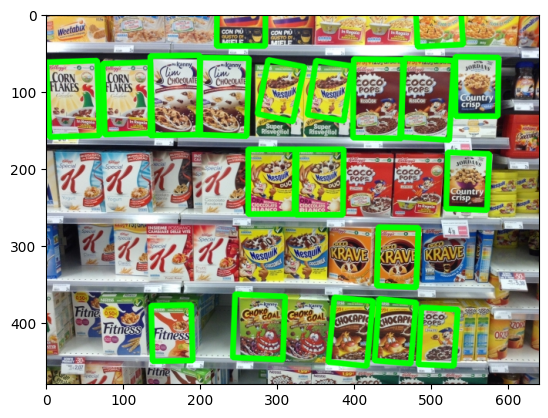

Product 0
Product 1
Product 2
	Instance 1:	Position: ((77, 117)) - Width: 47	Height: 70
Product 3
	Instance 1:	Position: ((305, 421)) - Width: 61	Height: 77
Product 4
	Instance 1:	Position: ((141, 129)) - Width: 60	Height: 96
	Instance 2:	Position: ((204, 130)) - Width: 63	Height: 100
Product 5
	Instance 1:	Position: ((270, 122)) - Width: 44	Height: 67
Product 7
	Instance 1:	Position: ((394, 133)) - Width: 61	Height: 97
	Instance 2:	Position: ((464, 133)) - Width: 59	Height: 95
	Instance 3:	Position: ((372, 242)) - Width: 55	Height: 88
Product 11
	Instance 1:	Position: ((426, 330)) - Width: 49	Height: 72
Product 14
	Instance 1:	Position: ((457, 423)) - Width: 48	Height: 80
Product 15
Product 16
	Instance 1:	Position: ((541, 22)) - Width: 57	Height: 68
Product 18
	Instance 1:	Position: ((506, 236)) - Width: 50	Height: 69
	Instance 2:	Position: ((532, 133)) - Width: 51	Height: 72
Product 19
Product 22
	Instance 1:	Position: ((289, 18)) - Width: 66	Height: 65
	Instance 2:	Position: ((224,

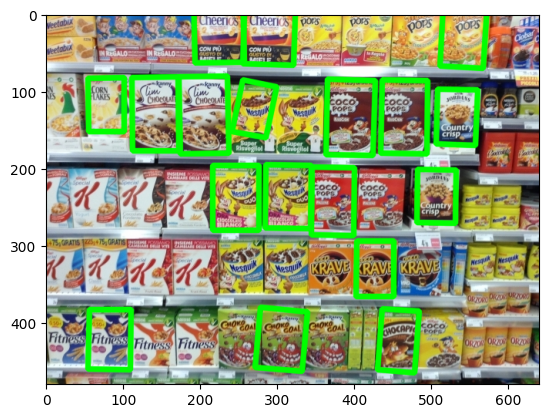

Product 0
Product 1
Product 2
	Instance 1:	Position: ((81, 387)) - Width: 46	Height: 67
Product 3
	Instance 1:	Position: ((456, 408)) - Width: 59	Height: 76
Product 4
	Instance 1:	Position: ((301, 119)) - Width: 58	Height: 92
	Instance 2:	Position: ((243, 120)) - Width: 58	Height: 93
Product 7
	Instance 1:	Position: ((491, 116)) - Width: 61	Height: 97
	Instance 2:	Position: ((564, 115)) - Width: 63	Height: 100
	Instance 3:	Position: ((466, 228)) - Width: 56	Height: 89
Product 11
	Instance 1:	Position: ((523, 316)) - Width: 49	Height: 73
Product 14
	Instance 1:	Position: ((556, 414)) - Width: 51	Height: 84
Product 15
Product 18
	Instance 1:	Position: ((611, 219)) - Width: 54	Height: 74
Product 19
	Instance 1:	Position: ((637, 113)) - Width: 29	Height: 73
Product 22
	Instance 1:	Position: ((322, 10)) - Width: 62	Height: 54
	Instance 2:	Position: ((384, 7)) - Width: 63	Height: 52
Product 24
Product 26
	Instance 1:	Position: ((340, 223)) - Width: 58	Height: 81
	Instance 2:	Position: ((407,

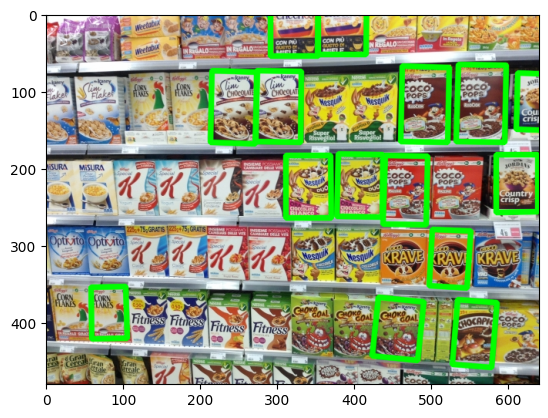

Product 0
Product 1
Product 2
	Instance 1:	Position: ((84, 130)) - Width: 66	Height: 97
Product 3
	Instance 1:	Position: ((265, 438)) - Width: 69	Height: 86
	Instance 2:	Position: ((328, 439)) - Width: 66	Height: 83
Product 4
	Instance 1:	Position: ((151, 126)) - Width: 66	Height: 105
	Instance 2:	Position: ((215, 128)) - Width: 63	Height: 100
Product 5
	Instance 1:	Position: ((353, 120)) - Width: 48	Height: 72
Product 7
	Instance 1:	Position: ((421, 131)) - Width: 64	Height: 103
	Instance 2:	Position: ((485, 130)) - Width: 63	Height: 100
Product 11
	Instance 1:	Position: ((446, 338)) - Width: 51	Height: 77
	Instance 2:	Position: ((387, 337)) - Width: 53	Height: 79
Product 12
	Instance 1:	Position: ((136, 450)) - Width: 60	Height: 72
Product 14
	Instance 1:	Position: ((388, 439)) - Width: 51	Height: 83
	Instance 2:	Position: ((447, 437)) - Width: 53	Height: 87
Product 15
Product 16
	Instance 1:	Position: ((566, 16)) - Width: 58	Height: 64
Product 18
	Instance 1:	Position: ((538, 237)) 

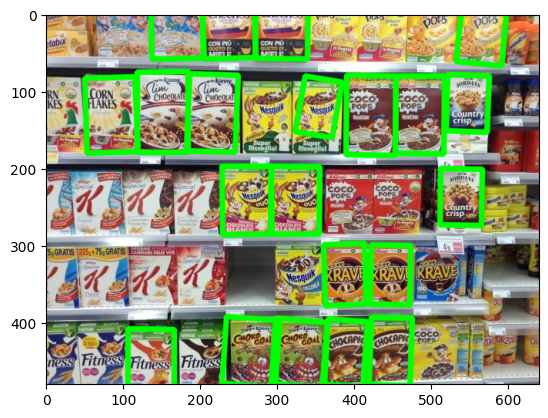

Product 0
Product 1
	Instance 1:	Position: ((463, 338)) - Width: 59	Height: 76
Product 2
	Instance 1:	Position: ((33, 119)) - Width: 51	Height: 77
Product 3
	Instance 1:	Position: ((338, 441)) - Width: 62	Height: 78
	Instance 2:	Position: ((280, 439)) - Width: 53	Height: 68
Product 4
	Instance 1:	Position: ((101, 134)) - Width: 65	Height: 103
	Instance 2:	Position: ((166, 136)) - Width: 66	Height: 105
Product 5
	Instance 1:	Position: ((235, 127)) - Width: 48	Height: 72
Product 7
	Instance 1:	Position: ((444, 137)) - Width: 65	Height: 105
	Instance 2:	Position: ((369, 138)) - Width: 66	Height: 106
Product 8
Product 9
	Instance 1:	Position: ((38, 339)) - Width: 58	Height: 77
Product 11
	Instance 1:	Position: ((344, 343)) - Width: 54	Height: 80
	Instance 2:	Position: ((405, 343)) - Width: 57	Height: 86
Product 12
	Instance 1:	Position: ((106, 442)) - Width: 54	Height: 74
	Instance 2:	Position: ((163, 445)) - Width: 49	Height: 68
Product 14
	Instance 1:	Position: ((435, 431)) - Width: 49	H

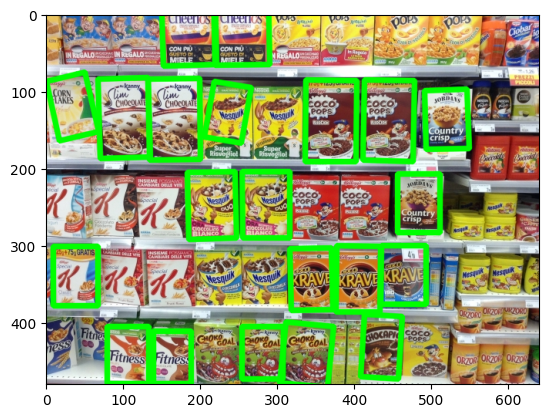

In [76]:
MIN_GOOD_MATCHES = 4

imgs_scene = ['scenes/h1.jpg','scenes/h2.jpg','scenes/h3.jpg','scenes/h4.jpg','scenes/h5.jpg']

for scene in imgs_scene:
    img_train = cv2.imread(scene)[:,:,::-1]
    for model in range(27):
        img_model=cv2.imread(f"models/{model}.jpg")[:,:,::-1]
        img_model=adaptImage(img_model)        
        img_train = find_object(img_query = img_model, product = model, img_train = img_train, MIN_GOOD_MATCHES = MIN_GOOD_MATCHES)
    plt.imshow(img_train)
    plt.show()
